[INFO] loading images...


F:\anaconda\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 163s 2s/step - loss: 0.3228 - accuracy: 0.8635 - val_loss: 0.0884 - val_accuracy: 0.9896
Epoch 2/20
95/95 [==============================] - 163s 2s/step - loss: 0.1152 - accuracy: 0.9637 - val_loss: 0.0518 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 156s 2s/step - loss: 0.0831 - accuracy: 0.9717 - val_loss: 0.0408 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 163s 2s/step - loss: 0.0732 - accuracy: 0.9730 - val_loss: 0.0381 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 154s 2s/step - loss: 0.0541 - accuracy: 0.9822 - val_loss: 0.0340 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 159s 2s/step - loss: 0.0521 - accuracy: 0.9838 - val_loss: 0.0313 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 152s 2s/step - loss: 0.0451 - accuracy: 0.9845 - val

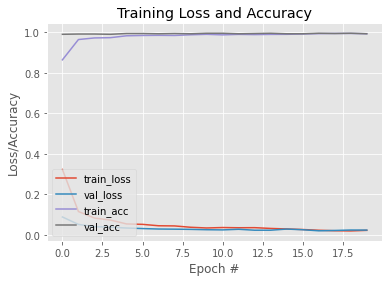

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"Deep\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]


data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")